<a href="https://colab.research.google.com/github/masud1901/Human-Emotion-Detection/blob/main/Copy_of_ResNet50_with_Bloodcell_dataset_and_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Connecting Kaggle to Colab**

In [ ]:
!mkdir -p ~/.kaggle
!cp "/content/gdrive/My Drive/kaggleJson/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading the dataset

In [ ]:
! kaggle datasets download -d paultimothymooney/blood-cells
!unzip blood-cells.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

importing the required libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from keras.layers import Input,Lambda,Dense,Flatten
from keras import Model
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import tensorflow as tf


In [ ]:
#re-sizing all images to this size
IMAGE_SIZE = [224,224]

#training config
epochs = 10
batch_size= 64

In [ ]:
train_path = '/content/dataset2-master/dataset2-master/images/TRAIN'
val_path = '/content/dataset2-master/dataset2-master/images/TEST'


# useful for getting the number of files
image_files = glob(train_path + '/*/*.jp*g')
val_image_files = glob(val_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

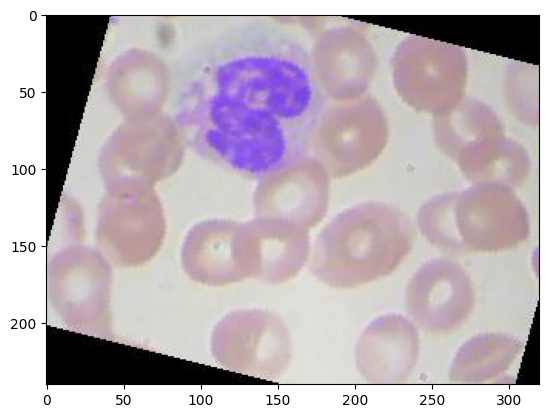

In [ ]:
# looking at a random image

plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

Fitting the resnet50 model

In [ ]:
# add preprocessing layer to the front of ResNet50
res = ResNet50(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)
# not training the existing weights
for layer in res.layers:
  layer.trainable = False

# our layer x - that is executed using funtional API
x = Flatten()(res.output)
x = Dense(1024,activation='relu' ) (x)
x = Dense(256,activation='relu' ) (x)
x = Dense(128,activation='relu' ) (x)
prediction = Dense(len(folders),activation = 'softmax')(x)


#create a model object
model = Model(inputs= res.input , outputs = prediction)

#view the structure of the model
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.01),
    metrics = ['accuracy']
)

**Creating the Image to feed into the vgg16**

In [ ]:
gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min: -123.68 max: 149.73004


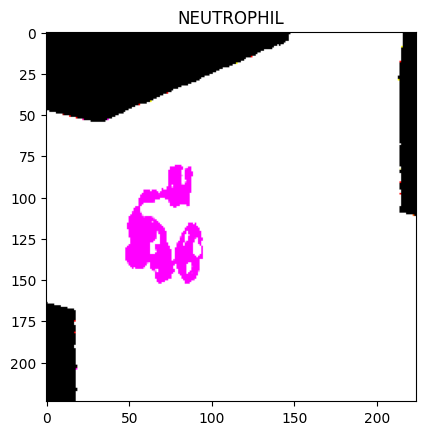

In [ ]:
# testing the generator to see how it works and some other usefull things

# get label mapped for confusion matrix plot later
test_gen = gen.flow_from_directory(val_path, target_size = IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None]* len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
  labels[v]=k

# should be strangely colored image (sue to VGG weights being BGR)
for x,y in test_gen:
  print("min:",x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


In [ ]:
#create generator

train_generator = gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

val_generator = gen.flow_from_directory(
    val_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
# fit the model

r = model.fit(
    train_generator,
    validation_data=val_generator,
      epochs=10,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(val_image_files) // batch_size,
    verbose=1
)

Epoch 1/10
  1/155 [..............................] - ETA: 49:54 - loss: 2.3552 - accuracy: 0.2969

KeyboardInterrupt: ignored

In [ ]:
# making a confusion matrix

def get_confusion_matrix(data_path,N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix" , N)
  predictions = []
  targets = []
  i = 0
  for x,y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle = False, batch_size=batch_size*2):
    i+=1
    if i%50 ==0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis =1)
    y = np.argmax(y, axis = 1)
    predictions = np.concatenate((predictions,p))
    targets = np.concatenate((targets,y))
    if len(targets)>=N:
      break

  cm = confusion_matrix(targets,predictions)
  return cm


In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

In [ ]:
val_cm = get_confusion_matrix(val_path, len(image_files))
print(val_cm)

Plotting some data

In [ ]:
#loss

plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'val loss')
plt.legend()
plt.show()

In [ ]:
# acccuracy

plt.plot(r.history['accuracy'],label = 'train acc')
plt.plot(r.history['val_accuracy'],label = 'val acc')
plt.legend()
plt.show()


In [ ]:
# visualising training cm
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# visualising validation cm
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **Callbacks**

In [ ]:
class LossCallBack(Callback):
  def on_epoch_end(self,epoch,logs):
    print(f"\n ForEpoch Number {epoch+1} the model has a loss of this {logs['loss']}")
  def on_batch_end(self,batch,logs):
    print(f"\n For Batch Number {batch+1} the model has a loss of this {logs}")

CSVLogger

In [ ]:
csv_callback = tf.keras.callbacks.CSVLogger(
    'log_checks.csv', separator=',', append=False
)

Early stopper

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

Learning Rate Scheduler

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)


lr_callback = tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=1
)

Model Checkpoint

In [ ]:
mc_callback = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/',
    monitor='val_loss',
    verbose= 1,
    save_best_onl = True,
    save_weights_only= False,
    mode:'auto',
    save_freq='epoch',
)

ReduceLearningRateOnPlateau

In [ ]:
reduceLR_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
)

In [ ]:

history = model.fit(
    train_generator,
    validation_data=val_generator,
      epochs=3,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(val_image_files) // batch_size,
    verbose=1,
    callbacks=[csv_callback,es_callback,lr_callback,mc_callback,reduceLR_callback]
)